In [1]:
# Refer from
#  https://pasus.tistory.com/138
#  https://horomary.hatenablog.com/entry/2020/06/26/003806
#  https://keras.io/examples/rl/ddpg_pendulum/
#
import gym
import sys
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, concatenate, Lambda
from collections import deque
import matplotlib.pyplot as plt

In [2]:
class Actor(tf.keras.Model):
    def __init__(self, state_size, action_size, action_min, action_max):
        super(Actor, self).__init__()
        self.action_min = action_min
        self.action_max = action_max

        self.fc1 = Dense(64, activation='relu')
        self.fc2 = Dense(64, activation='relu')
        # self.fc3 = Dense(16, activation='relu')
        self.out= Dense(action_size, activation='tanh',kernel_initializer = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)) # -1 ~ +1

    def call(self, x):
        x       = self.fc1(x)
        x       = self.fc2(x)
        # x       = self.fc3(x)
        action  = self.out(x)
        # return self.projected_to_action_space(action)
        a = Lambda(lambda x: x*self.action_max)(action)
        return a

class Critic(tf.keras.Model):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.s1 = Dense(16, activation='relu')
        self.s2 = Dense(32, activation='relu')
        self.a1 = Dense(32, activation='relu')
        self.a2 = Dense(32, activation='relu')
        self.fc1= Dense(64, activation='relu')
        self.fc2= Dense(64, activation='relu')
        self.out= Dense(1,  activation='linear')

    def call(self,state,action):
        # state  = state_action[0]
        # action = state_action[1]
        s = self.s1(state)
        s = self.s2(s)
        a = self.a1(action)
        a = self.a2(a)
        c = concatenate([s,a],axis=-1)
        x = self.fc1(c)
        x = self.fc2(x)
        q = self.out(x)
        return q

In [3]:
class TD3Agent:
    def __init__(self, state_size, action_size, action_min, action_max):
        self.state_size = state_size
        self.action_size= action_size
        self.action_min = action_min
        self.action_max = action_max

        # Hyper params for learning
        self.discount_factor = 0.99
        self.actor_learning_rate  = 0.001
        self.critic_learning_rate = 0.002
        self.tau = 0.005

        # Experience Replay
        self.batch_size = 64
        self.train_start = 2000
        self.memory = deque(maxlen=50000)

        # self.critic         = get_critic(self.state_size, self.action_size)
        # self.target_critic  = get_critic(self.state_size, self.action_size)
        # self.actor          = get_actor(self.state_size, self.action_size, self.action_max)
        # self.target_actor   = get_actor(self.state_size, self.action_size, self.action_max)
        self.critic1_optimizer   = tf.keras.optimizers.Adam(lr=self.critic_learning_rate)
        self.critic2_optimizer   = tf.keras.optimizers.Adam(lr=self.critic_learning_rate)
        self.actor_optimizer    = tf.keras.optimizers.Adam(lr=self.actor_learning_rate)

        self.critic1        = Critic(self.state_size, self.action_size)
        self.critic2        = Critic(self.state_size, self.action_size)
        self.target_critic1 = Critic(self.state_size, self.action_size)
        self.target_critic2 = Critic(self.state_size, self.action_size)
        self.actor          = Actor(self.state_size, self.action_size, self.action_min, self.action_max)
        self.target_actor   = Actor(self.state_size, self.action_size, self.action_min, self.action_max)

        self.actor.build(input_shape=(None, self.state_size))
        self.target_actor.build(input_shape=(None, self.state_size))
        state_in = Input((self.state_size,))
        action_in = Input((self.action_size,))
        self.actor(state_in)
        self.target_actor(state_in)
        self.critic1(state_in, action_in)
        self.critic2(state_in, action_in)
        self.target_critic1(state_in, action_in)
        self.target_critic2(state_in, action_in)

        self.actor.summary()
        self.critic1.summary()
        self.critic2.summary()
        
        self.target_actor.set_weights(self.actor.get_weights())
        self.target_critic1.set_weights(self.critic1.get_weights())
        self.target_critic2.set_weights(self.critic2.get_weights())

        self.update_freq = 2
        self.train_idx = 0
        self.show_media_info = False

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def update_target_model(self):
        tau = self.tau
        for (net, target_net) in zip(   self.actor.trainable_variables,
                                        self.target_actor.trainable_variables):
            target_net.assign(tau * net + (1.0 - tau) * target_net)
        for (net, target_net) in zip(   self.critic1.trainable_variables,
                                        self.target_critic1.trainable_variables):
            target_net.assign(tau * net + (1.0 - tau) * target_net)
        for (net, target_net) in zip(   self.critic2.trainable_variables,
                                        self.target_critic2.trainable_variables):
            target_net.assign(tau * net + (1.0 - tau) * target_net)

    def get_action(self,state):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        action = self.actor(state)
        noise = np.random.random(self.action_size)
        # Exploration and Exploitation
        return np.clip(action.numpy()[0]+noise,self.action_min,self.action_max)

    def train_model(self):
        # Train from Experience Replay
        # Training Condition - Memory Size
        if len(self.memory) < self.train_start:
            return
        # Sampling from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        
        states      = tf.convert_to_tensor(np.array([sample[0] for sample in mini_batch]))
        actions     = tf.convert_to_tensor(np.array([sample[1] for sample in mini_batch]))
        rewards     = tf.convert_to_tensor(np.array([sample[2] for sample in mini_batch]),dtype=tf.float32)
        rewards     = tf.expand_dims(rewards, axis = 1)
        next_states = tf.convert_to_tensor(np.array([sample[3] for sample in mini_batch]))
        dones       = tf.convert_to_tensor(np.array([sample[4] for sample in mini_batch]),dtype=tf.float32)
        dones       = tf.expand_dims(dones, axis = 1)
        
        if self.show_media_info == False:
            self.show_media_info = True
            print('Start to train, check batch shapes')
            print('**** shape of states', np.shape(states),type(states))
            print('**** shape of actions', np.shape(actions),type(actions))
            print('**** shape of rewards', np.shape(rewards),type(rewards))
            print('**** shape of next_states', np.shape(next_states),type(next_states))
            print('**** shape of dones', np.shape(dones),type(dones))

        target_actions = self.target_actor(next_states,training=True)
        target_q1 = self.target_critic1(next_states,target_actions,training=True)
        target_q2 = self.target_critic2(next_states,target_actions,training=True)
        target_q = tf.minimum(target_q1,target_q2)
        with tf.GradientTape() as tape:
            target_value = rewards + (1.0 - dones) * self.discount_factor * target_q
            q = self.critic1(states, actions, training=True)
            critic1_loss = tf.math.reduce_mean(tf.math.square(target_value - q))
        critic1_params = self.critic1.trainable_variables
        critic1_grads = tape.gradient(critic1_loss, critic1_params)
        self.critic1_optimizer.apply_gradients(zip(critic1_grads, critic1_params))

        with tf.GradientTape() as tape:
            target_value = rewards + (1.0 - dones) * self.discount_factor * target_q
            q = self.critic2(states, actions, training=True)
            critic2_loss = tf.math.reduce_mean(tf.math.square(target_value - q))
        critic2_params = self.critic2.trainable_variables
        critic2_grads = tape.gradient(critic2_loss, critic2_params)
        self.critic2_optimizer.apply_gradients(zip(critic2_grads, critic2_params))

        self.train_idx = self.train_idx + 1
        if self.train_idx % self.update_freq == 0:
          with tf.GradientTape() as tape:
              new_actions = self.actor(states,training=True)
              new_q = self.critic1(states, new_actions,training=True)
              actor_loss = -tf.reduce_mean(new_q)
          actor_params = self.actor.trainable_variables
          actor_grads = tape.gradient(actor_loss, actor_params)
          self.actor_optimizer.apply_gradients(zip(actor_grads, actor_params))

          self.update_target_model()
        return

    def save_model(self):
        self.actor.save_weights("./save_model/pendulum_td3_TF_actor", save_format="tf")
        self.critic1.save_weights("./save_model/pendulum_td3_TF_critic1", save_format="tf")
        self.critic2.save_weights("./save_model/pendulum_td3_TF_critic2", save_format="tf")
        return


Model: "actor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             multiple                  256       
_________________________________________________________________
dense_29 (Dense)             multiple                  4160      
_________________________________________________________________
dense_30 (Dense)             multiple                  65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________
Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  64        
_________________________________________________________________
dense_1 (Dense)              multiple                  544       
___________________________________________

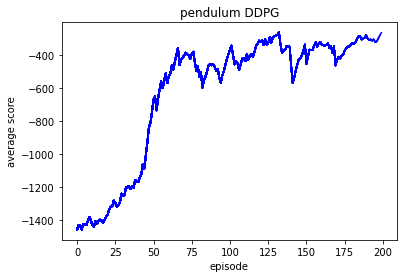

In [4]:
# %matplotlib tk

ENV_NAME = 'Pendulum-v0'
EPISODES = 300
END_SCORE = -200

if __name__ == "__main__":
    env = gym.make(ENV_NAME)
    state_size  = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    action_min  = env.action_space.low[0]
    action_max  = env.action_space.high[0]

    agent = TD3Agent(state_size, action_size, action_min, action_max)
    print('Env Name : ',ENV_NAME)
    print('States {0}, Actions {1}'.format(state_size, action_size))
    print('Action space {0:.2f} ~ {1:.2f}'.format(action_min, action_max))
    scores, episodes = [], []
    score_avg = 0

    end = False
    show_media_info = True
    
    fig = plt.figure(1)
    fig.clf()
    
    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        while not done:
            # env.render()

            # Interact with env.
            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.train_model()
            state = next_state

            # 
            score += reward
            if show_media_info:
                print("State Shape : ", np.shape(state))
                print("Action Shape : ", np.shape(action))
                print("Reward Shape : ", np.shape(reward))
                print("done Shape : ", np.shape(done))
                show_media_info = False
            if done:
                score_avg = 0.9 * score_avg + 0.1 * score if score_avg != 0 else score
                print("episode: {0:3d} | score avg: {1:3.2f} | mem size {2:6d} |"
                    .format(e, score_avg, len(agent.memory)))

                episodes.append(e)
                scores.append(score_avg)

                plt.plot(episodes, scores, 'b')
                plt.xlabel('episode')
                plt.ylabel('average score')
                plt.title('pendulum DDPG')
                plt.grid()
                plt.savefig("./save_model/pendulum_td3_TF.png")

                # 이동 평균이 0 이상일 때 종료
                if score_avg > END_SCORE:
                    agent.save_model()
                    end = True
                    break
        if end == True:
            env.close()
            np.save('./save_model/data/pendulum_td3_TF_epi',  episodes)
            np.save('./save_model/data/pendulum_td3_TF_score',scores)
            print("End")
            break

In [5]:
env.close()